In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
import math

# Suppress only DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Suppress only UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

def plot(*args):
    count = len(args)
    fig, ax = plt.subplots(1,count)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    if count==1:
        ax.imshow(args[0], cmap="gray")
    else:
        for i in range(len(ax)):
            ax[i].imshow(args[i], cmap="gray")
    plt.show()

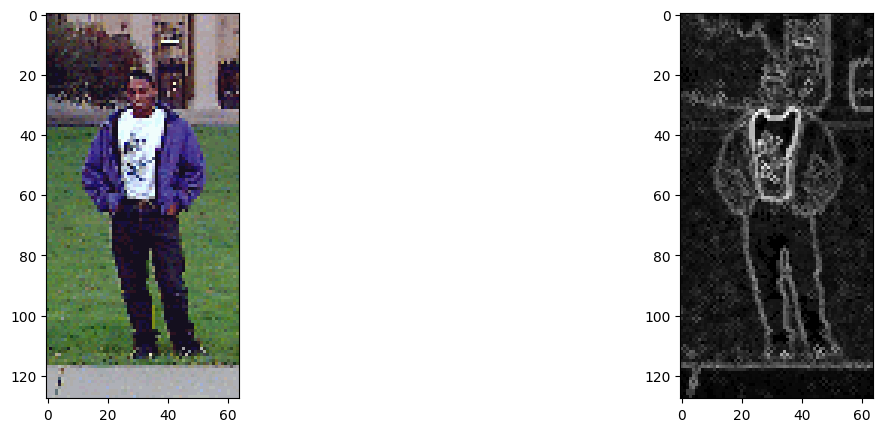

In [16]:
def calculate_am_and_orent(image):
    image_copy = image.astype(np.int32)
    dx = scipy.ndimage.filters.convolve1d(np.int32(image_copy), np.array([-1, 0, 1]), 1)
    dy = scipy.ndimage.filters.convolve1d(np.int32(image_copy), np.array([-1, 0, 1]), 0)
    
    am = np.sqrt(dx**2 + dy**2)
    
    max_val_index = np.argmax(am, axis=2)
    
    max_am = np.choose(max_val_index, [am[:,:,0], am[:,:,1],  am[:,:,2]])
    
    max_orientation = np.arctan2(np.choose(max_val_index, [dy[:,:,0], dy[:,:,1],  dy[:,:,2]]),
                                 np.choose(max_val_index, [dx[:,:,0], dx[:,:,1],  dx[:,:,2]]))

    max_orientation =  np.rad2deg(max_orientation)
    max_orientation[max_orientation < 0] += 180
    max_orientation %= 180
    
    return max_am, max_orientation


image = cv2.imread("pos/per00060.ppm")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

am, orien = calculate_am_and_orent(image)

plot(image, am)


In [26]:
bins = [20, 40, 60, 80, 100, 120, 140, 160, 180]

def search_idx(ang):
    lower_idx = 0
    higher_idx = len(bins) - 1

    while lower_idx <= higher_idx:
        mid_idx = (lower_idx + higher_idx) // 2
        if bins[mid_idx] == ang:
            return mid_idx
        elif bins[mid_idx] < ang:
            lower_idx = mid_idx + 1
        else:
            higher_idx = mid_idx - 1

    return lower_idx


def hog(image):
    cell_size=8
    num_of_bins = 9
    am, orient = calculate_am_and_orent(image)
    Y, X, _ = image.shape
    YY_cell, XX_cell = np.int32(Y/cell_size), np.int32(X/cell_size)
    
    histogram = np.zeros((YY_cell, XX_cell, num_of_bins))
    
    for y in range(YY_cell):
        for x in range(XX_cell):
            cell_am = am[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            cell_orientation = orient[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            
            for i in range(cell_size):
                for j in range(cell_size):
                    curr_am = cell_am[i, j]
                    curr_orient = cell_orientation[i, j]
                    
                    angle_index = search_idx(curr_orient)
                    threshold = bins[angle_index]

                    histogram[y,x,angle_index] += curr_am
                    
                    lower_bound = threshold - 15
                    upper_bound = threshold -5
                    
                    v_upper_bound = curr_am * (curr_orient - lower_bound) / 20
                    v_lower_bound = curr_am * (upper_bound - curr_orient) / 20
                    
                    histogram[y, x, (angle_index +1) %9] += v_upper_bound
                    histogram[y, x, (angle_index -1) %9] += v_lower_bound

    return normalize_blocks(histogram)  
            


def normalize_blocks(histogram, epsilon=1e-5):
    YY_cell, XX_cell, _ = histogram.shape
    normalized_hog = []

    for j in range(YY_cell - 1):
        for i in range(XX_cell - 1):
            block_hist = np.concatenate((
                histogram[j, i, :],
                histogram[j, i+1, :],
                histogram[j+1, i, :],
                histogram[j+1, i+1, :]
            ))
            norm = np.linalg.norm(block_hist)
            normalized_block = block_hist / np.sqrt(norm**2 + epsilon**2)
            normalized_hog.append(normalized_block)

    return np.concatenate(normalized_hog)

img = cv2.imread("./pos/per00060.ppm")
x = hog(img)
print(x[:20])

[0.34752823 0.15800991 0.09257091 0.13647062 0.12451099 0.09624949
 0.12017287 0.16863664 0.22074944 0.18455618 0.064127   0.2481764
 0.24807873 0.26122594 0.2765002  0.15326482 0.12651587 0.26393268
 0.16708727 0.16565746]


In [27]:
hog_data = np.zeros([2*100, 3781], np.float32)

for i in range(100):
    IP = cv2.imread("pos/per%05d.ppm"%(i+1))
    IN = cv2.imread("neg/neg%05d.png"%(i+1))
    F = hog(IP)
    hog_data[i,0] = 1
    hog_data[i, 1:] = F
    
    F = hog(IN)
    
    hog_data[i+100,0] = 0
    hog_data[i+100,1:] = F
    

In [28]:
labels = hog_data[:, 0]
data = hog_data[:, 1:]

In [119]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = svm.SVC(kernel='linear', C=1.0)

clf.fit(data, labels)

SVC(kernel='linear')

In [120]:
y_pred = clf.predict(data)
cm = confusion_matrix(labels, y_pred)

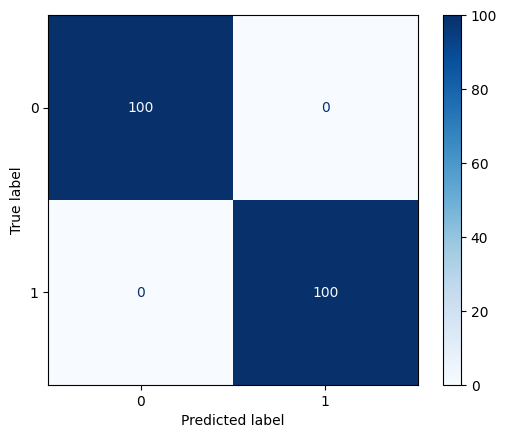

Accuracy: 1.0


In [121]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = y_pred == labels
accuracy = accuracy.astype("uint8")

print("Accuracy: " + str(sum(accuracy)/len(accuracy)))

# CZESC 3

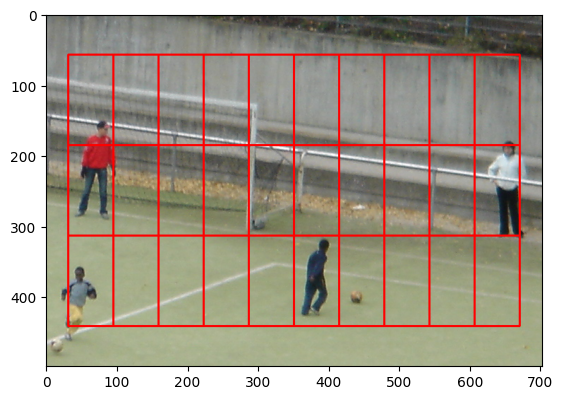

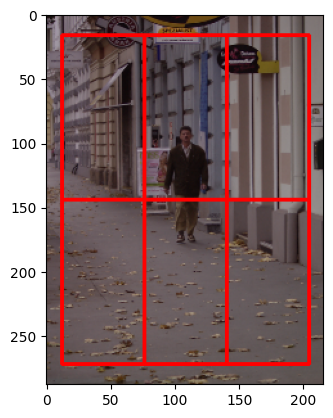

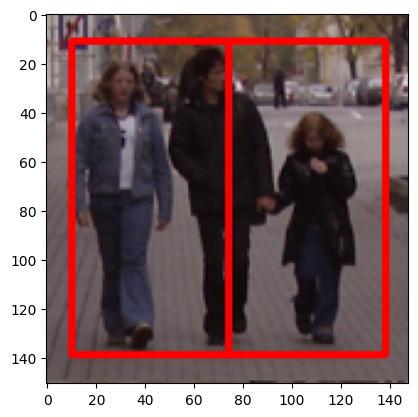

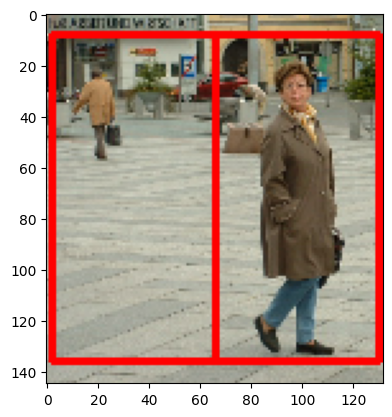

In [127]:
def show_boxes(image):
    image_copy = image.copy()
    window_size_y, window_size_x = 128, 64

    Y,X, _ = image_copy.shape

    start_y = int((Y - window_size_y * (Y // window_size_y)) /2)
    start_x = int((X - window_size_x * (X // window_size_x)) /2)

    for y in range(start_y, Y - window_size_y, window_size_y):
        for x in range(start_x, X-window_size_x, window_size_x):
            cv2.rectangle(image_copy, (x,y), (x+window_size_x, y+window_size_y), (255,0,0), 2)

    plt.imshow(image_copy)
    plt.show()



image_1 = cv2.imread("testImage1.png")
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
# image_1 = cv2.resize(image_1, (int(image_1.shape[1]*0.8), int(image_1.shape[0]*0.8)))

image_2 = cv2.imread("testImage2.png")
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
image_2 = cv2.resize(image_2, (int(image_2.shape[1]*0.45), int(image_2.shape[0]*0.45)))

image_3 = cv2.imread("testImage3.png")
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB)

image_4 = cv2.imread("testImage4.png")
image_4 = cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB)
image_4 = cv2.resize(image_4, (int(image_4.shape[1]*0.4), int(image_4.shape[0]*0.4)))

for img in [image_1, image_2, image_3, image_4]:
    show_boxes(img)



In [128]:
def get_distance(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    if x1_max < x2_min:  # box1 is to the left of box2
        x_distance = x2_min - x1_max
    elif x2_max < x1_min:  # box2 is to the left of box1
        x_distance = x1_min - x2_max
    else:  # boxes overlap in the x direction
        x_distance = 0

    if y1_max < y2_min:  # box1 is above box2
        y_distance = y2_min - y1_max
    elif y2_max < y1_min:  # box2 is above box1
        y_distance = y1_min - y2_max
    else:  # boxes overlap in the y direction
        y_distance = 0

    return math.sqrt(x_distance ** 2 + y_distance ** 2)

def merge_boxes(boxes):
    x_min = min(box[0] for box in boxes)
    y_min = min(box[1] for box in boxes)
    x_max = max(box[2] for box in boxes)
    y_max = max(box[3] for box in boxes)
    return [x_min, y_min, x_max, y_max]

def merge_nearby_bounding_boxes(bounding_boxes, threshold):
    merged = True
    while merged:
        merged = False
        to_merge = set()
        n = len(bounding_boxes)

        # Mark boxes to merge
        for i in range(n):
            for j in range(i + 1, n):
                if get_distance(bounding_boxes[i], bounding_boxes[j]) <= threshold:
                    to_merge.add(i)
                    to_merge.add(j)

        # Create new list of bounding boxes by merging the marked ones
        new_bounding_boxes = []
        skip = set()
        for i in range(n):
            if i in skip:
                continue
            if i in to_merge:
                group = [bounding_boxes[i]]
                for j in range(i + 1, n):
                    if j in to_merge and get_distance(bounding_boxes[i], bounding_boxes[j]) <= threshold:
                        group.append(bounding_boxes[j])
                        skip.add(j)
                new_bounding_boxes.append(merge_boxes(group))
                merged = True
            else:
                new_bounding_boxes.append(bounding_boxes[i])

        bounding_boxes = new_bounding_boxes

    return bounding_boxes


In [131]:
def detect(im, resize_scale=1, step=16):
    im_cp = im.copy()
    im_cp = cv2.resize(im_cp, (int(im_cp.shape[1] / resize_scale), int(im_cp.shape[0] / resize_scale)))
    h, w = im_cp.shape[:2]
    sw_h, sw_w = 128, 64
    
    
    boxes = []
    for y in range(0, h - sw_h, step):
        for x in range(0, w - sw_w, step):
            window = im[y:y+sw_h, x:x+sw_w]
            F = hog(window)
            prediction = clf.predict([F])
            if prediction == 1:
                boxes.append((x,y,x+sw_w, y + sw_h))


    filtered_labels = merge_nearby_bounding_boxes(boxes, 1)

    filtered_labels = [(x,y,w,h) for x,y,w,h in filtered_labels]

    for i in range(len(filtered_labels)):
        x, y, w, h = filtered_labels[i]
        a_w = w - x
        a_h = h - y
        if a_h > a_w:
            cv2.rectangle(im_cp, (x, y), (x + a_w, y + a_h), (0, 255, 0), 2)
    
    return im_cp

96.0 1
470.84604702598915 1
260.4611295375953 1
271.5290039756342 1
304.42076144704714 1
116.48175822848829 1
131.93938001976514 1
208.0 1
208.0 1
0.0 1
96.0 1
470.84604702598915 1
260.4611295375953 1
304.42076144704714 1
116.48175822848829 1
208.0 1


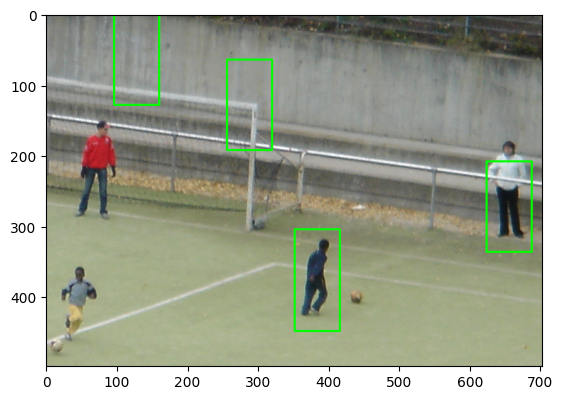

0.0 1
0.0 1
0.0 1


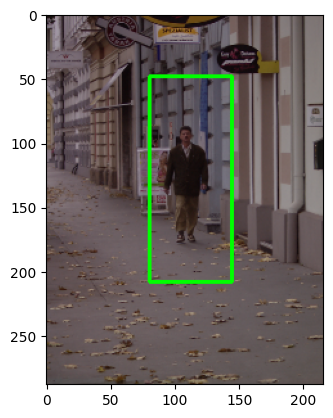

0.0 1


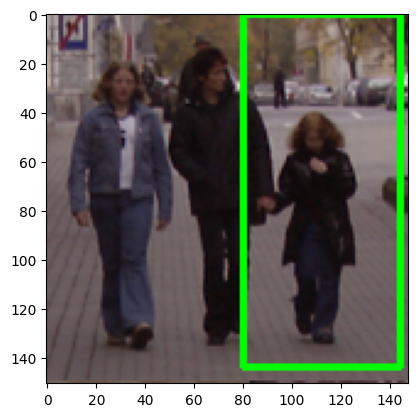

0.0 1


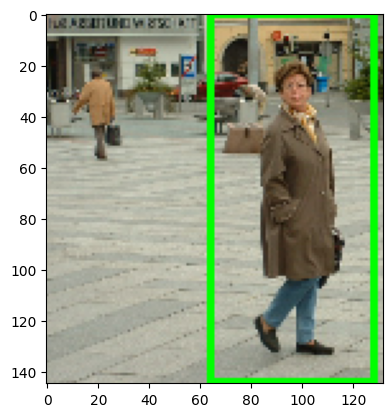

In [132]:
for img in [image_1, image_2, image_3, image_4]:
    res = detect(img)
    
    plt.imshow(res)
    plt.show()